# Email Authorship Classification

## Loading the Data
---

In [1]:
#Import statements
import torch, pickle, os, sys, random, time
import nltk
import time, gc, regex, json
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from sklearn.metrics import f1_score, accuracy_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim
from collections import *
import numpy as np
import pdb
import math
from transformers import *
from tqdm.notebook import tqdm
from transformers import logging
logging.set_verbosity_error()

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
rob_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\15007\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\15007\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\15007\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
C:\Users\15007\anaconda3\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


### Pre-Processing Algorithm


For each person:
1. Look at the line that begins with `X-FileName`, `x_num`
2. Look at, if exists, the `-----Original Message----` line, `o_num`
3. Look at, if exists, the `---------------------- Forwarded by` line, `f_num`
4. Read everything after `x_num` until `o_num` or `f_num` and trim whitespace
5. If `o_num` or `f_num` does not exist, read to end of file and trim whitespace.
6. Prepend `<SOS>` and append an `<EOS>` at the end of every email.
**Issue: Not all emails follow the same format so there is still some noise in the data**




In [2]:
from charset_normalizer import from_path
import os
if not os.path.isfile(f'enron_mail_20150507.tar.gz'):
    os.system(f'wget https://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz')
if not os.path.isdir('maildir'):
    os.system(f'tar -xvf enron_mail_20150507.tar.gz')

idx_to_author = [x for x in os.listdir('maildir') if 'sent_items' in os.listdir(f'maildir/{x}')]
author_to_id = {v: i for i, v in enumerate(idx_to_author)}
author_to_mail = {}

if not os.path.isdir('emails'):
    os.makedirs('emails')

    for author in tqdm(idx_to_author):
        fbar = tqdm([x for x in os.listdir(f'maildir/{author}/sent_items') if os.path.isfile(f'maildir/{author}/sent_items/{x}')])
        fbar.set_description(f"{author}")
        all_write = ''
        for name in fbar:
            email_content = str(from_path(f'maildir/{author}/sent_items/{name}').best()).split('\n')
            to_write = ''
            startReading = False
            for line in email_content:
                if '-----Original' in line.split():break
                if '----------------------' in line.split(): break
                if startReading:
                    to_write += line.strip() + '\n'
                if 'X-FileName:' in line.split():
                    startReading = True
            if to_write.isspace(): continue
            if '-' in to_write.split()[0]: continue
            all_write += f'<SOS>{to_write.strip()}<EOS>'
        os.makedirs(f'emails/{author}', exist_ok=True)
        with open(f'emails/{author}/mails.txt', 'w', encoding='utf-8') as f:
            f.write(all_write)
for author in tqdm(idx_to_author):
    with open(f'emails/{author}/mails.txt', 'r') as f:
        author_to_mail[author] = regex.findall('(?<=<SOS>)[^\a]*?(?=<EOS>)', f.read(), regex.M)

  0%|          | 0/136 [00:00<?, ?it/s]

## Building Dictionaries of Data
---
### Important Variables
  1. `author_to_mail :: String -> List(String)`
  2. `author_to_mail_pos`
  3. `author_to_trigrams_w`
  4. `author_to_starting_bigrams_w`
  5. `author_to_unigrams_w`
  6. `author_to_punc`
  7. `author_to_trigrams_p`
  8. `author_to_starting_bigrams_p`
  9. `author_to_unigrams_p`

### Map Authors to Raw Emails

The following are some simple statistics of the dataset

244.625


Text(0, 0.5, 'Number of emails')

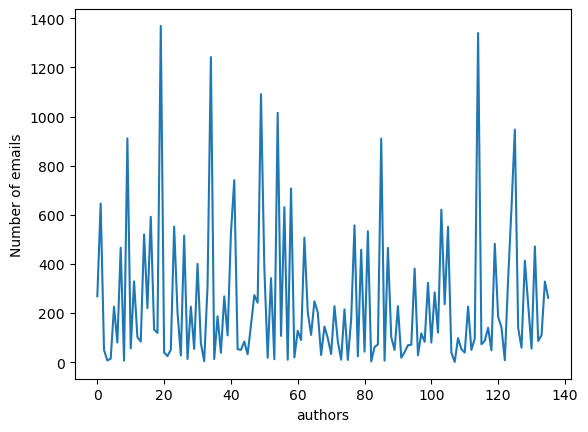

In [3]:
import matplotlib.pyplot as plt

author_count = 0
mail_per_author = []
for author, list_of_mail in author_to_mail.items():
    author_count += 1
    mail_per_author.append(len(list_of_mail))

print(np.mean(mail_per_author))
plt.plot(range(author_count),mail_per_author)
plt.xlabel('authors')
plt.ylabel('Number of emails')


Text(0, 0.5, 'Count')

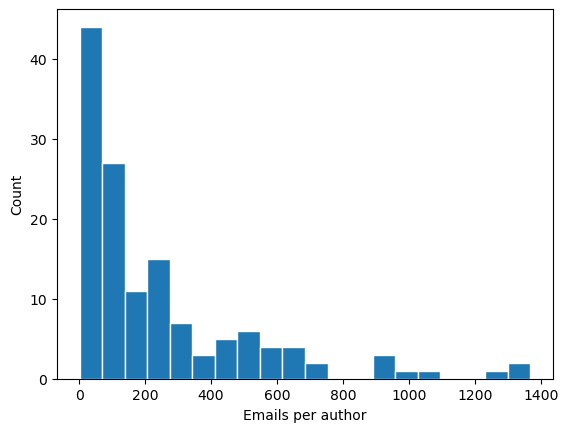

In [4]:
plt.hist(mail_per_author, edgecolor='white',bins=20)
plt.xlabel("Emails per author")
plt.ylabel('Count')

bert_tokenizer## Creating Pytorch Datasets and Dataloaders
---
### **Important Variables**
1. `training_set` and `test_set` \

These variables are of type `torch.utils.data.Dataset` which you can index into like a list and respond to `len(training_set)` and `len(test_set)`

### Author-Email Dataset Class

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
#Define an author dataset class with PyTorch
class EmailDataset(Dataset):

    #list_of_pairs -> List(Author, Email) for all author-email pairs in the dataset
    #Index bounds is [0, len(list_of_pairs))
    def __init__(self, list_of_pairs):
        self.pairs = list_of_pairs

        self.MAX_SEQ_LEN = 220
    def __len__(self):
        return len(self.pairs)

    #Return a dictionary: {'author': author, 'email': email}
    def __getitem__(self, idx):
        to_return = {}
        author, email = self.pairs[idx]
        #print(author + '| ' + email)
        to_return['author'] = author
        to_return['email'] = email
        return to_return

class RNNDataset(Dataset):

    #list_of_pairs -> List(Author, Space-sep tokens) for all author-email pairs in the dataset
    #Index bounds is [0, len(list_of_pairs))
    def __init__(self, list_of_pairs):
        self.pairs = list_of_pairs
        self.MAX_SEQ_LEN = 220
    def __len__(self):
        return len(self.pairs)

    #Return a dictionary: {'author': author, 'email': email}
    def __getitem__(self, idx):
        to_return = {}
        author, email = self.pairs[idx]
        #print(author + '| ' + email)
        to_return['author'] = author
        to_return['email'] = email
        return to_return

class BERTDataset(Dataset):

    #list_of_pairs -> List(Author, Space-sep tokens) for all author-email pairs in the dataset
    #Index bounds is [0, len(list_of_pairs))
    def __init__(self, list_of_pairs):
        self.pairs = list_of_pairs
        self.MAX_SEQ_LEN = 220
    def __len__(self):
        return len(self.pairs)
  
    #Return a dictionary: {'author': author, 'email': email}
    def __getitem__(self, idx):
        to_return = {}
        author, email = self.pairs[idx]
        #print(author + '| ' + email)
        to_return['author'] = author
        to_return['email'] = email
        return to_return

#PRECONDITION: No <SOS> or <EOS> in email
#for classification use on input
#for lm use on input and target
def str_to_rnntok(email, max_seq_len):
    tokens = email
    idx_of_last_word = len(tokens) - 1
    tokens += ['<PAD>'] * (max_seq_len - len(tokens))
    idxs = [word_to_idx[word] for word in tokens]
    return (idxs, idx_of_last_word)

def str_to_berttok(email, max_seq_len):
    tokens = email
    tokens = list(map(int, tokens))
    # maximum sequence length for this model is 512
    tokens = [bert_tokenizer.cls_token_id] + tokens + [bert_tokenizer.sep_token_id]
    idx_of_last_word = len(tokens) - 1
    tokens = tokens[:max_seq_len]
    tokens += [rob_tokenizer.pad_token_id] * (max_seq_len - len(tokens))
    return (tokens, idx_of_last_word)

def str_to_robtok(email, max_seq_len):
    tokens = email
    tokens = list(map(int, tokens))
    tokens = [rob_tokenizer.cls_token_id] + tokens + [rob_tokenizer.eos_token_id]
    idx_of_last_word = len(tokens) - 1
    tokens = tokens[:max_seq_len]
    tokens += [rob_tokenizer.pad_token_id] * (max_seq_len - len(tokens))
    return (tokens, idx_of_last_word)

### Splitting the Data into Train and Test
---
**Algorithm** \
  1. Select a train/test ratio (currently: `80/20`)
  2. Transform the dictionary into a list of tuples
    1. Maintain a dictionary from author to number of emails
  2. For every datapoint:
    1. For a newly seen author, if he/she has few emails, select this datapoint to be in the training dataset
    2. Otherwise, probabilistically select if the datapoint should belong to train or test
  4. Create corresponding dataloaders

    

*Issues* \
  1. Authors of few email may be under-represented or not represented at all
  2. Authors of many emails may be over-represented

*Solutions* \
  1. For every author that has less than $n$ emails, guarantee that he/she will have at least one email in the training set
  2. For every author that has less than $n$ emails will be dropped from the dataset
  3. For every author that has more than $m$ emails, downsample such that the author will have exactly `MAX_MAIL` emails in the dataset
  4. For every author that has less than $n$ emails, bootstrap sample such that the author will have exactly `MIN_MAIL` emails in the dataset

*Possible Modifications to Solutions* \
  1. For solutions 3 and 4, don't set a hard limit but make it proportional to distance to the mean to maintain relative representation in the data

Currently, solution 1 is in use. $n$ is chosen to be 100 as a histogram shows the mode to be 100.

In [6]:
split_data = lambda arr, train_size, test_size: (arr[:train_size], arr[train_size:train_size+test_size], arr[train_size+test_size:])
tokenize_corpus = lambda a_tokenizer, corpus: a_tokenizer.convert_tokens_to_ids(a_tokenizer.tokenize(corpus))

objs = ['training_list', 'test_list', 'valid_list']
objs += [f'{x}_bert' for x in objs] + [f'{x}_rob' for x in objs] + [f'{x}_nltk' for x in objs]
objs.append('idx_to_word')

if not os.path.isdir('data'):
    os.makedirs('data')

    train_data, test_data, valid_data = [], [], []
    for author, emails in author_to_mail.items():
        train_size = len(emails) * 6 // 10
        test_size = (len(emails) - train_size) // 2
        all_data = [(author, email) for email in emails]
        train_temp, test_temp, valid_temp = split_data(all_data, train_size, test_size)
        train_data.extend(train_temp)
        test_data.extend(test_temp)
        valid_data.extend(valid_temp)

    all_data = train_data + test_data + valid_data

    vocabulary = set()
    training_list, test_list, valid_list = split_data(all_data, len(train_data), len(test_data))

    list_bert = [(x[0], tokenize_corpus(bert_tokenizer, x[1])) for x in tqdm(all_data)]
    list_bert = [(x[0], ' '.join([str(y) for y in x[1]])) for x in list_bert]
    training_list_bert, test_list_bert, valid_list_bert = split_data(list_bert, len(train_data), len(test_data))

    list_rob = [(x[0], tokenize_corpus(rob_tokenizer, x[1])) for x in tqdm(all_data)]
    list_rob = [(x[0], ' '.join([str(y) for y in x[1]])) for x in list_rob]
    training_list_rob, test_list_rob, valid_list_rob = split_data(list_rob, len(train_data), len(test_data))

    list_nltk = list(all_data)
    for x in tqdm(all_data):
        vocabulary.update(nltk.word_tokenize(x[1]))

    training_list_nltk, test_list_nltk, valid_list_nltk = split_data(all_data, len(train_data), len(test_data))
    idx_to_word = list(vocabulary)
    idx_to_word.append('<PAD>')
    for o in objs:
        obj = globals()[o]
        with open(f'data/{o}.txt', 'w') as f:
            json.dump(obj, f)
else:
    for o in objs:
        with open(f'data/{o}.txt', 'r') as f:
            globals()[o] = json.load(f)
    
    
word_to_idx = {idx_to_word[k]: k for k in range(len(idx_to_word))}  
    
#Create dataset variables
training_size = len(training_list)
test_size = len(test_list)
valid_size = len(valid_list)
print(f'train size: {training_size}')
print(f'test size: {test_size}')
print(f'valid size: {valid_size}')
print(f'vocab size: {len(idx_to_word) - 1}')
training_set = EmailDataset(training_list)
test_set = EmailDataset(test_list)
valid_set = EmailDataset(valid_list)
training_set_bert = BERTDataset(training_list_bert)
test_set_bert = BERTDataset(test_list_bert)
valid_set_bert = BERTDataset(valid_list_bert)
training_set_rob = BERTDataset(training_list_rob)
test_set_rob = BERTDataset(test_list_rob)
valid_set_rob = BERTDataset(valid_list_rob)
training_set_nltk = RNNDataset(training_list_nltk)
test_set_nltk = RNNDataset(test_list_nltk)
valid_set_nltk = RNNDataset(valid_list_nltk)

train size: 19907
test size: 6656
valid size: 6706
vocab size: 77376


## Neural Model Classes

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### RNN-Like Classifier

In [8]:
class RNNClassifier(nn.Module):
    def __init__(self, params):
        super(RNNClassifier, self).__init__()
        self.num_authors = params['num_authors']
        self.vocab_size = params['vocab_size']
        self.d_emb = params['d_emb']
        self.d_hid = params['d_hid']
        self.n_layer = 1
        self.batch_size = params['batch_size']
        
        self.encoder = nn.Embedding(self.vocab_size, self.d_emb)
        self.rnn_type = params['type']
        if self.rnn_type == 'RNN':
            self.rnn = nn.RNN(self.d_emb, self.d_hid, self.n_layer, batch_first=True)
        elif self.rnn_type == 'GRU':
            self.rnn = nn.GRU(self.d_emb, self.d_hid, self.n_layer, batch_first=True)
        elif self.rnn_type == 'LSTM':
            self.rnn = nn.LSTM(self.d_emb, self.d_hid, self.n_layer, batch_first=True)
        elif self.rnn_type == 'BiLSTM':
            self.rnn = nn.LSTM(self.d_emb, self.d_hid//2, self.n_layer, batch_first=True, bidirectional=True)
        self.decoder = nn.Linear(self.d_hid, self.num_authors)
        
    def forward(self, batch, list_of_idx):
        hidden = torch.zeros(self.n_layer, batch.size(0), self.d_hid, device=device)
        embedding = self.encoder(batch)
        batch_seq_len = batch.shape[1]
        mask_tensor = torch.zeros([self.batch_size, 1, batch_seq_len], device=device)
        for i in range(len(list_of_idx)):
            mask_tensor[i, 0, list_of_idx[i]] = 1
        embedding = torch.squeeze(embedding)
        if self.rnn_type == 'LSTM' or self.rnn_type == 'BiLSTM':
            output, _ = self.rnn(embedding)
        else:
            output, _ = self.rnn(embedding, hidden)
        last_hidden = torch.bmm(mask_tensor, output)
        torch.squeeze(last_hidden)
        logits = self.decoder(last_hidden)
        return logits

### Hand-Written BiLSTM

In [9]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, params):
        super(BiLSTMClassifier, self).__init__()
        self.num_authors = params['num_authors']
        self.vocab_size = params['vocab_size']
        self.d_emb = params['d_emb']
        self.d_hid = params['d_hid']
        self.n_layer = 1
        self.batch_size = params['batch_size']
        
        self.encoder = nn.Embedding(self.vocab_size, self.d_emb)
        self.rnn_type = params['type']
        self.rnn = nn.LSTM(self.d_emb, self.d_hid, self.n_layer, batch_first=True)
        self.rnn_rev = nn.LSTM(self.d_emb, self.d_hid, self.n_layer, batch_first=True)
        self.decoder = nn.Linear(self.d_hid*2, self.num_authors)
        
    def forward(self, batch, rev_batch, list_of_idx):
        embedding = self.encoder(batch)
        embedding_rev = self.encoder(rev_batch)
        batch_seq_len = batch.shape[1]
        mask_tensor = torch.zeros([self.batch_size, 1, batch_seq_len], device=device)
        for i in range(len(list_of_idx)):
            mask_tensor[i, 0, list_of_idx[i]] = 1
        embedding = torch.squeeze(embedding)
        embedding_rev = torch.squeeze(embedding_rev)
        output, _ = self.rnn(embedding)
        output_rev, _ = self.rnn_rev(embedding_rev)
        last_hidden = torch.bmm(mask_tensor, output)
        last_hidden_rev = torch.bmm(mask_tensor, output_rev)
        torch.squeeze(last_hidden)
        torch.squeeze(last_hidden_rev)
        final_cat = torch.cat([last_hidden, last_hidden_rev], dim=2)
        logits = self.decoder(final_cat)
        return logits

In [10]:
def find_seq_len(list_of_mail):
    return len(max(list_of_mail, key=len))
def find_seq_len_bert(list_of_mail):
    return len(max(list_of_mail, key=len)) + 2

## Training Loops for All Neural Models
---
In this section, load and preprocess data for the appropriate tasks of: \
  1. RNN Classification
  2. ~~RNN LM~~
  3. BERT Classification \

The models that will be trained are: \
  1. RNN Classifier
  2. GRU Classifier
  3. LSTM Classifier
  4. Bi-LSTM Classifier (classify on concatenation of final hidden states)
  5. ~~RNN-like LM (Specific type of RNN will be determined by the best classifier)~~
  6. Fine-Tuned BERT Classifier
  
  
**Our Novel Approach** \
Freeze the BERT weights and encode every email. Write author + encoded email vectors. ~~Additionally, encode + write pairs for RNN-like LM.~~ Replicate the previous work with these new vectors.


In [11]:
!mkdir model

A subdirectory or file model already exists.


### RNN Classification

In [13]:
def train_rnn_classifier():
    #Create dataloader variables
    batch_size = 16
    shuffle = True
    training_loader = DataLoader(training_set_nltk, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_set_nltk, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(valid_set_nltk, batch_size=batch_size, shuffle=shuffle)

    #Optimal RNN/GRU: 0.0005
    #Optimal LSTM/BiLSTM: 0.002776
    #Optimized on batch_size of 16
    epochs = 10
    accuracy_list = []
    iter_counter = 0
    MAX_SEQ = 1024
    params = {}
    params['num_authors'] = len(author_to_mail)
    params['vocab_size'] = len(idx_to_word)
    params['batch_size'] = batch_size
    params['d_emb'] = 512
    params['d_hid'] = 1024
    params['type'] = 'RNN'
    params['learning_rate'] = 1e-3
    torch.cuda.empty_cache()
    net = RNNClassifier(params)
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=params['learning_rate'])
    epoch_bar = tqdm(range(epochs), desc='Epoch', position=0)
    all_acc = 0
    for epoch in epoch_bar:
        ep_loss = 0
        iter_bar = tqdm(training_loader, desc='Iteration', position=1, leave=True)
        train_acc = 0
        for step, sample in enumerate(iter_bar): # gives batch data
            #Turn list of authors into list of indicies
            target_list = [author_to_id[name] for name in sample['author']]
            target = torch.tensor(target_list, device=device, dtype=torch.long)
            emails = [nltk.word_tokenize(x) for x in sample['email']]
            if len(emails) != batch_size:
                continue
            #Find max seq len for this batch 
            batch_seq_len = find_seq_len(emails)
            if batch_seq_len > MAX_SEQ:
                continue
            token_idxs = [str_to_rnntok(email, batch_seq_len) for email in emails]
            last_index = [x[1] for x in token_idxs]
            batch_list = [x[0] for x in token_idxs]
            batch = torch.tensor(batch_list, device=device, dtype=torch.long).unsqueeze(2)
            preds = net(batch, last_index)
            del batch
            preds = preds.contiguous().view(-1, net.num_authors)
            loss = criterion(preds, target)
            ep_loss += float(loss)

            preds = F.softmax(preds, dim=1).cpu().detach().numpy()
            pred = np.argmax(preds, axis=1)
            train_acc += accuracy_score(pred, target_list)
            del preds
            del target
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()
            iter_bar.set_description('Batch Loss: %3.2f | Acc: %3.3f Iteration: ' % (float(loss), train_acc / (step + 1)))
        
        iter_bar = tqdm(test_loader, desc='Val Iter', position=1, leave=True)
        num_correct = 0
        num_seen = 0
        for step, sample in enumerate(iter_bar): # gives batch data
            #Turn list of authors into list of indicies
            target_list = [author_to_id[name] for name in sample['author']]
            target = torch.tensor(target_list, device=device, dtype=torch.long)
            emails = [nltk.word_tokenize(x) for x in sample['email']]
            if len(emails) != batch_size:
                continue
            batch_seq_len = find_seq_len(emails)
            if batch_seq_len > MAX_SEQ:
                continue

            #Pad and build the batch and keep track of last idx of word
            #This idx will be important in the forward step to make a mask
            #To retrieve the last hidden state
            token_idxs = [str_to_rnntok(email, batch_seq_len) for email in emails]
            last_index = [x[1] for x in token_idxs]
            batch_list = [x[0] for x in token_idxs]
            batch = torch.tensor(batch_list, device=device, dtype=torch.long).unsqueeze(2)
            with torch.no_grad():
                preds = net(batch, last_index)
            del batch
            preds = preds.contiguous().view(-1, net.num_authors).softmax(dim=1).cpu().detach().numpy()
            pred = np.argmax(preds, axis=1)
            all_acc += accuracy_score(pred, target_list)
            del target
            accuracy_list.append(all_acc)
            iter_bar.set_description('Accuracy : %3.3f | Val Iter: ' % (all_acc / len(accuracy_list)))
        model_save_name = f'rnnacc_{epoch}.pt'
        path = f"model/{model_save_name}" 
        torch.save(net.state_dict(), path)
        print('Epoch %d | Loss: %f' % (epoch + 1, ep_loss))
    np.savetxt('model/rnn_accuracy.txt', accuracy_list)
    np.savetxt('model/rnn_f1.txt', f1_list)
train_rnn_classifier()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1245 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 1 | Loss: 3697.696536


Iteration:   0%|          | 0/1245 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 2 | Loss: 3346.673393


Iteration:   0%|          | 0/1245 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 3 | Loss: 3146.553494


Iteration:   0%|          | 0/1245 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 4 | Loss: 3021.194640


Iteration:   0%|          | 0/1245 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 5 | Loss: 2939.080052


Iteration:   0%|          | 0/1245 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 6 | Loss: 2832.474980


Iteration:   0%|          | 0/1245 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 7 | Loss: 2756.889917


Iteration:   0%|          | 0/1245 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 8 | Loss: 2669.133234


Iteration:   0%|          | 0/1245 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 9 | Loss: 2592.078210


Iteration:   0%|          | 0/1245 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/416 [00:00<?, ?it/s]

Epoch 10 | Loss: 2559.415834


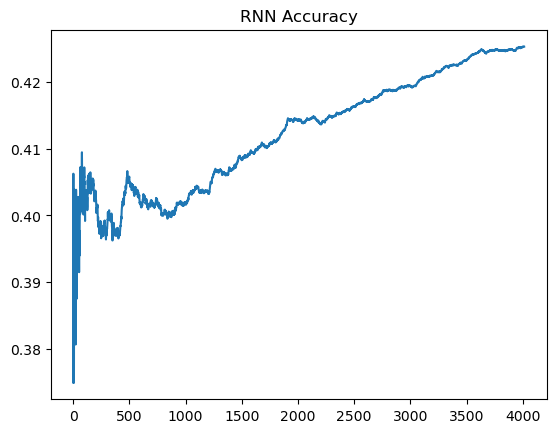

In [25]:
accuracy_list = np.loadtxt('model/rnn_accuracy.txt')
plt.title('RNN Accuracy')
plt.plot(list(range(len(accuracy_list))), np.array(accuracy_list) / np.arange(1, len(accuracy_list) + 1))
plt.show()
plt.close()

### BERT Classification

In [12]:
def train_bert_classifier():
    #Create dataloader variables
    batch_size = 2
    shuffle = True
    training_loader = DataLoader(training_set_bert, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_set_bert, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(valid_set_bert, batch_size=batch_size, shuffle=shuffle)

    torch.cuda.empty_cache()
    epochs = 5
    iter_counter = 0
    BERT_MAX = 512
    params = {}
    params['num_authors'] = len(author_to_mail)
    params['vocab_size'] = len(idx_to_word)
    params['batch_size'] = batch_size
    params['learning_rate'] = 3.5e-5
    net = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=params['num_authors'], output_attentions=False, output_hidden_states=False)
    net.to(device)
    time_total = len(training_loader) * epochs
    optimizer = optim.AdamW(net.parameters(), lr=params['learning_rate'])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=time_total)
    epoch_bar = tqdm(range(epochs), desc='Epoch', position=0)
    accuracy_list = []
    f1_list = []
    losses = []
    all_acc = 0
    for epoch in epoch_bar:
        ep_loss = 0
        loss_list = []
        iter_bar = tqdm(training_loader, desc='Train Iter', position=1, leave=True)
        net.train()
        for step, sample in enumerate(iter_bar):
            #Turn list of authors into list of indicies
            batch_time = time.time()
            target_list = [author_to_id[name] for name in sample['author']]
            target = torch.tensor(target_list, device=device, dtype=torch.long)
            emails = [x.split() for x in sample['email']]
            if len(emails) != batch_size:
                continue

            #Find max seq len for this batch 
            batch_seq_len = find_seq_len_bert(emails)
            if batch_seq_len > BERT_MAX:
                batch_seq_len = BERT_MAX
            
            batch_list = [str_to_berttok(email, batch_seq_len)[0] for email in emails]
            batch = torch.tensor(batch_list, device=device, dtype=torch.long)
            attn_mask = (batch > 0).to(torch.long)

            start = time.time()
            outputs = net(batch, attention_mask=attn_mask, labels=target)
            loss = outputs.loss
            ep_loss += float(loss)
            loss_list.append(float(loss))
            losses.append(float(loss))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            iter_bar.set_description('Loss: %3.2f | Batch Loss: %3.2f | Train Iter: ' % (ep_loss, float(loss)))
            del target
            del attn_mask
            del batch
            del outputs
            del loss

        net.eval()
        iter_bar = tqdm(valid_loader, desc='Val Iter', position=1, leave=True)
        num_correct = 0
        num_seen = 0
        for step, sample in enumerate(iter_bar):
            #Turn list of authors into list of indicies
            target_list = [author_to_id[name] for name in sample['author']]

            emails = [x.split() for x in sample['email']]
            if len(emails) != batch_size:
                continue

            #Find max seq len for this batch 
            batch_seq_len = find_seq_len_bert(emails)
            if batch_seq_len > BERT_MAX:
                batch_seq_len = BERT_MAX

            batch_list = [str_to_berttok(email, batch_seq_len)[0] for email in emails]
            batch = torch.tensor(batch_list, device=device, dtype=torch.long)
            attn_mask = (batch > 0).to(torch.long)
            #--Training goes here--
            with torch.no_grad():
                outputs = net(batch, attention_mask=attn_mask)
            pred = np.argmax(outputs[0].cpu().detach().numpy(), axis=1).flatten()
            all_acc += accuracy_score(pred, target_list)
            accuracy_list.append(all_acc)
            iter_bar.set_description('Accuracy: %3.2f | Val Iter: ' % (all_acc / len(accuracy_list)))
            del batch
            del attn_mask
            del outputs

        print('Epoch %d | Loss: %6.2f | Acc: %2.1f' % (epoch + 1, ep_loss, all_acc / len(accuracy_list)))
        model_save_name =  f'bert_{epoch}.pt'
        path = f"model/{model_save_name}" 
        torch.save(net.state_dict(), path)
    np.savetxt('model/bert_accuracy.txt', accuracy_list)
train_bert_classifier()

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train Iter:   0%|          | 0/9954 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/3353 [00:00<?, ?it/s]

Epoch 1 | Loss: 26148.73 | Acc: 0.6


Train Iter:   0%|          | 0/9954 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/3353 [00:00<?, ?it/s]

Epoch 2 | Loss: 16634.42 | Acc: 0.6


Train Iter:   0%|          | 0/9954 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/3353 [00:00<?, ?it/s]

Epoch 3 | Loss: 11303.01 | Acc: 0.6


Train Iter:   0%|          | 0/9954 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/3353 [00:00<?, ?it/s]

Epoch 4 | Loss: 6851.90 | Acc: 0.6


Train Iter:   0%|          | 0/9954 [00:00<?, ?it/s]

Val Iter:   0%|          | 0/3353 [00:00<?, ?it/s]

Epoch 5 | Loss: 4171.32 | Acc: 0.6


There are some outliers at the beginning of the training so they are discard in the grapy

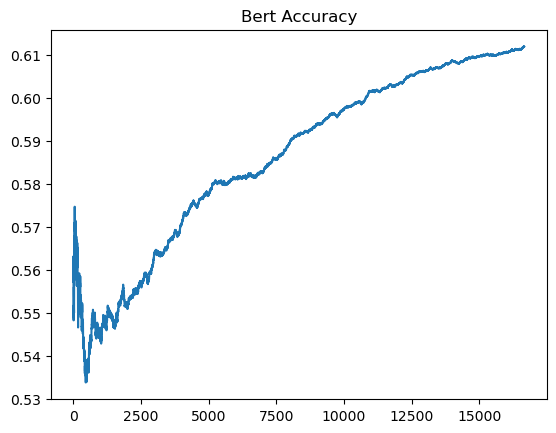

In [24]:
accuracy_list = np.loadtxt('model/bert_accuracy.txt')
plt.title('Bert Accuracy')
plt.plot(list(range(len(accuracy_list[100:]))), np.array(accuracy_list[100:]) / np.arange(101, len(accuracy_list[100:]) + 101))
plt.show()
plt.close()

### RNN Evaluation
---
Note: Will only work if you have the models stored locally in your Google Drive root directory

In [18]:
#RNN Models didn't store correctly, fail on training data
#Retrain from scratch
def model_eval():
    params = {}
    #Create dataloader variables
    batch_size = 16
    shuffle = True
    test_loader = DataLoader(test_set_nltk, batch_size=batch_size, shuffle=shuffle)
    iter_counter = 0
    MAX_SEQ = 8192
    params['num_authors'] = len(author_to_mail)
    params['vocab_size'] = len(idx_to_word)
    params['batch_size'] = batch_size
    params['d_emb'] = 512
    params['d_hid'] = 1024
    params['learning_rate'] = 1e-3
    
    params['type'] = 'RNN'
    net = RNNClassifier(params)
    net.load_state_dict(torch.load('model/rnnacc_9.pt'))
    net.to(device)
    net.eval()
    iter_bar = tqdm(test_loader, desc='Test Iter', position=1, leave=True)
    acc_list = []
    for step, sample in enumerate(iter_bar): # gives batch data
        #Turn list of authors into list of indicies
        target_list = [author_to_id[name] for name in sample['author']]
        target = torch.tensor(target_list, device=device, dtype=torch.long)
        emails = [nltk.word_tokenize(x) for x in sample['email']]
        if len(emails) != batch_size:
            continue
        #Find max seq len for this batch 
        batch_seq_len = find_seq_len(emails)
        if batch_seq_len > MAX_SEQ:
            continue
        token_idxs = [str_to_rnntok(email, batch_seq_len) for email in emails]
        last_index = [x[1] for x in token_idxs]
        batch_list = [x[0] for x in token_idxs]
        batch = torch.tensor(batch_list, device=device, dtype=torch.long).unsqueeze(2)
        preds = net(batch, last_index)
        preds = preds.contiguous().view(-1, net.num_authors).softmax(dim=1).cpu().detach().numpy()
        pred = np.argmax(preds, axis=1)
        acc = accuracy_score(pred, target_list)
        acc_list.append(acc)
        del target
        iter_bar.set_description('Accuracy : %3.3f | Test Iter: ' % (acc))
    del net
    print('RNN Accuracy: %3.3f' % np.mean(acc_list))
model_eval()

Test Iter:   0%|          | 0/416 [00:00<?, ?it/s]

RNN Accuracy: 0.431


### BERT Evaluation

In [20]:
def model_eval_bert():
    #Create dataloader variables
    batch_size = 2
    shuffle = True
    training_loader = DataLoader(training_set_bert, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_set_bert, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(valid_set_bert, batch_size=batch_size, shuffle=shuffle)

    epochs = 5
    iter_counter = 0
    BERT_HID = 768
    BERT_MAX = 512
    params = {}
    params['num_authors'] = len(author_to_mail)
    params['vocab_size'] = len(idx_to_word)
    params['batch_size'] = batch_size
    params['learning_rate'] = 3.5e-5
    net = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=params['num_authors'])
    net.load_state_dict(torch.load('model/bert_4.pt'))
    net.to(device)
    net.eval()
    ep_loss = 0
    loss_list = []
    accuracy_list = []
    iter_bar = tqdm(test_loader, desc='Test Iter', position=1, leave=True)
    net.train()
    for step, sample in enumerate(iter_bar):     # gives batch data
        #Turn list of authors into list of indicies
        batch_time = time.time()
        target_list = [author_to_id[name] for name in sample['author']]
        target = torch.tensor(target_list, device=device, dtype=torch.long)
        emails = [x.split() for x in sample['email']]
        if len(emails) != batch_size:
            continue

        #Find max seq len for this batch 
        batch_seq_len = find_seq_len_bert(sample['email'])
        if batch_seq_len > BERT_MAX:
            batch_seq_len = BERT_MAX
            
        batch_list = [str_to_berttok(email, batch_seq_len)[0] for email in emails]
        batch = torch.tensor(batch_list, device=device, dtype=torch.long)
        attn_mask = (batch > 0).to(torch.long)

        with torch.no_grad():    
            outputs = net(batch, attention_mask=attn_mask)
        prob = outputs[0].softmax(dim=1).cpu().detach().numpy()
        pred = np.argmax(prob, axis=1)
        acc = accuracy_score(pred, target_list)
        accuracy_list.append(acc)
        iter_bar.set_description('Accuracy: %3.2f | Test Iter: ' % (acc))
        del target
        del attn_mask
        del batch
        del outputs
    print(np.mean(accuracy_list))
model_eval_bert()

Test Iter:   0%|          | 0/3328 [00:00<?, ?it/s]

0.6137319711538461


## Vector Approach

### Constructing Email Vectors

In [27]:
def build_bert_vectors():
    author_to_cls = defaultdict(list)
    author_to_logit = defaultdict(list)
    #Create dataloader variables
    batch_size = 2
    shuffle = True
    training_loader = DataLoader(training_set_bert, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_set_bert, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(valid_set_bert, batch_size=batch_size, shuffle=shuffle)

    epochs = 5
    iter_counter = 0
    BERT_HID = 768
    BERT_MAX = 512
    params = {}
    params['num_authors'] = len(author_to_mail)
    params['vocab_size'] = len(idx_to_word)
    params['batch_size'] = batch_size
    params['d_hid'] = BERT_HID
    params['learning_rate'] = 3.5e-5
    num_iters = math.floor(training_size/batch_size) - 1
    net = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                         num_labels=params['num_authors'],
                                                         output_hidden_states=True)
    net.load_state_dict(torch.load(f'model/bert_2.pt'))
    net.to(device)
    net.eval()
    ep_loss = 0
    num_seen = 0
    num_correct = 0
    loss_list = []
    iter_bar = tqdm(training_loader, desc='Train Iter', position=1, leave=True)
    for step, sample in enumerate(iter_bar):     # gives batch data
        #Turn list of authors into list of indicies
        batch_time = time.time()
        target_list = [author_to_id[name] for name in sample['author']]
        target = torch.tensor(target_list, device=device, dtype=torch.long)
        emails = [x.split() for x in sample['email']]
        if len(emails) != batch_size:
            continue

        #Find max seq len for this batch 
        batch_seq_len = find_seq_len_bert(emails)
        if batch_seq_len > BERT_MAX:
            batch_seq_len = BERT_MAX

        #Build segment tensor
        #Pad and build the batch and keep track of last idx of word
        #This idx will be important in the forward step to make a mask
        #To retrieve the last hidden state
        batch_list = []
        for i in range(len(emails)):
            email = emails[i]
            #Get BERT tokenization
            token_idxs, idx = str_to_berttok(email, batch_seq_len)
            #Build input tensors
            batch_list.append(token_idxs)
        batch = torch.tensor(batch_list, device=device, dtype=torch.long)
        attn_mask = (batch != bert_tokenizer.pad_token_id).to(torch.long)
        with torch.no_grad():    
            outputs = net(batch, attention_mask=attn_mask)
        logits = outputs[0].cpu()
        h_states = outputs[1][12].cpu()
        cls_states = h_states[:,0,:].cpu()
        for i in range(len(target_list)):
            author_to_cls[target_list[i]].append(cls_states[i])
            author_to_logit[target_list[i]].append(logits[i])
        del target
        del attn_mask
        del batch
        del outputs
    torch.save(author_to_cls, "model/cls_vecs.dict")
    torch.save(author_to_logit, "model/logit_vecs.dict")
build_bert_vectors()

Train Iter:   0%|          | 0/9954 [00:00<?, ?it/s]

### Probe AGS Distribution

loading ags structures...
load complete
ags structures loaded
converting to tensors...
conversion complete


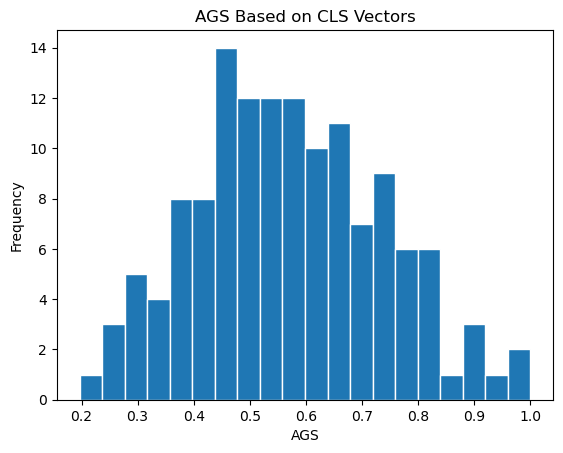

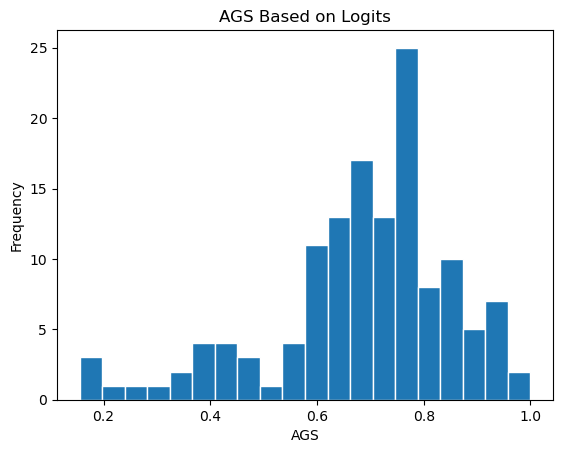

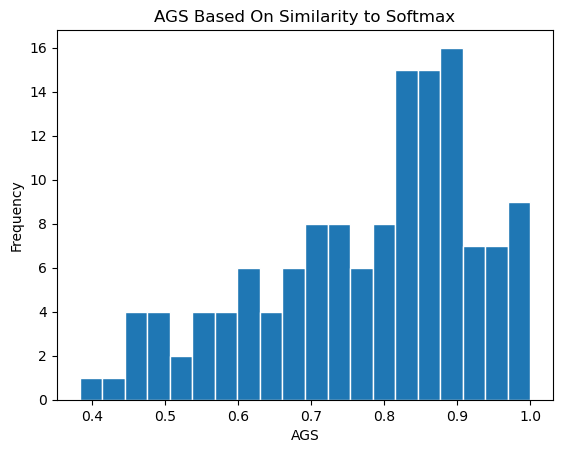

In [14]:
def test_ags():
    author_to_cls = defaultdict(list)
    author_to_cls_ags = defaultdict(float)
    author_to_logit = defaultdict(list)
    author_to_logit_ags = defaultdict(float)

    print('loading ags structures...')
    author_to_cls = torch.load("model/cls_vecs.dict")
    author_to_logit = torch.load("model/logit_vecs.dict")
    #author_to_cls_ags = torch.load(cls_ags_path)
    #author_to_logit_ags = torch.load(logit_ags_path)
    print('load complete')
    author_to_logit_tensor = {}
    author_to_logit_mean = {}
    author_to_logit_norm = {}
    author_to_logit_sims = {}
    author_to_cls_sims = {}
    print('ags structures loaded')
    print('converting to tensors...')
    #Idea, author level soft max dist
    #Average logits and soft max
    #Unlike handcrafted, cannot use traditional from paper
    #no correlation between logit similarity and classification
    #emails from same authors will have bigrams but logits abstract
    #logits will have similar softmax dist
    for author_id, list_of_embs in author_to_logit.items():
        logit_mat = torch.stack(list_of_embs)
        norm_mat = torch.norm(logit_mat, dim=1)
        norm_mat.to(device)
        square_norm = torch.mm(norm_mat.unsqueeze(1), torch.t(norm_mat.unsqueeze(1)))
        sims = torch.mm(logit_mat, torch.t(logit_mat)) / square_norm
        sims = torch.mean(sims, dim=1)
        #dist_mat = soft_mat - softmax_mat
        #sims = torch.norm(dist_mat,dim=1)
        author_to_logit_ags[author_id] = float(torch.mean(sims))
        #author_to_logit_mean[author_id] = softmax_mat

    for author_id, list_of_embs in author_to_cls.items():
        cls_mat = torch.stack(list_of_embs)
        norm_mat = torch.norm(cls_mat, dim=1)
        norm_mat.to(device)
        square_norm = torch.mm(norm_mat.unsqueeze(1), torch.t(norm_mat.unsqueeze(1)))
        sims = torch.mm(cls_mat, torch.t(cls_mat)) / square_norm
        sims = torch.mean(sims, dim=1)
        #dist_mat = soft_mat - softmax_mat
        #sims = torch.norm(dist_mat,dim=1)
        author_to_cls_ags[author_id] = float(torch.mean(sims))

    for author_id, list_of_embs in author_to_logit.items():
        logit_mat = torch.stack(list_of_embs)
        mean_mat = torch.mean(logit_mat, dim=0)
        softmax_mat = F.softmax(mean_mat, dim=0)
        softmax_mat.to(device)
        softmax_mean = softmax_mat.unsqueeze(dim=1)
        soft_mat = F.softmax(logit_mat, dim=1)
        soft_mat.to(device)
        norm_mat = torch.norm(soft_mat, dim=1)
        norm_mat.to(device)
        norms = norm_mat * float(torch.norm(softmax_mat))
        sims = torch.mm(soft_mat, softmax_mean)
        sims = torch.squeeze(sims) / norms
        #dist_mat = soft_mat - softmax_mat
        #sims = torch.norm(dist_mat,dim=1)
        author_to_logit_sims[author_id] = float(torch.mean(sims))
        author_to_logit_tensor[author_id] = soft_mat.cpu()
        author_to_logit_norm[author_id] = norm_mat.cpu()
        author_to_logit_mean[author_id] = softmax_mat.cpu()
    del logit_mat
    del mean_mat
    del softmax_mat
    del softmax_mean
    del soft_mat
    del norm_mat
    #print(author_to_logit_ags)
    #print(author_to_cls_ags)
    print('conversion complete')
    '''
    plt.figure()
    tensor_dist = author_to_logit_mean[10]
    print(tensor_dist.shape)
    soft_dist = F.softmax(tensor_dist, dim=0).cpu().detach().numpy()
    dist = tensor_dist.cpu().detach().numpy()
    plt.plot(range(len(dist)), dist, 'ro')
    plt.show()
    '''
    
    plt.figure()
    plt.hist(author_to_cls_ags.values(), edgecolor='white',bins=20)
    plt.xlabel("AGS")
    plt.ylabel('Frequency')
    plt.title('AGS Based on CLS Vectors')

    plt.figure()
    plt.hist(author_to_logit_ags.values(), edgecolor='white',bins=20)
    plt.xlabel("AGS")
    plt.ylabel('Frequency')
    plt.title('AGS Based on Logits')

    plt.figure()
    plt.hist(author_to_logit_sims.values(), edgecolor='white', bins=20)
    plt.xlabel("AGS")
    plt.ylabel('Frequency')
    plt.title('AGS Based On Similarity to Softmax')
    
    torch.save(author_to_cls_ags, 'model/cls_ags.dict')
    torch.save(author_to_logit_ags, 'model/logit_ags.dict')
test_ags()

### Evaluate CLS Vectors

In [22]:
def eval_cls_ags():
    print('loading ags structures...')
    author_to_cls = defaultdict(list)
    author_to_cls_ags = defaultdict(float)
    author_to_logit = defaultdict(list)
    author_to_logit_ags = defaultdict(float)

    author_to_logit = torch.load('model/cls_vecs.dict')
    author_to_logit_ags = torch.load('model/cls_ags.dict')
    author_to_logit_tensor = {}
    author_to_logit_mean = {}
    author_to_logit_norm = {}
    author_to_logit_sims = {}
    print('ags structures loaded')
    print('converting to tensors...')

    for author_id, list_of_embs in author_to_logit.items():
        logit_mat = torch.stack(list_of_embs)
        norm_mat = torch.norm(logit_mat, dim=1)
        norm_mat.to(device)
        square_norm = torch.mm(norm_mat.unsqueeze(1), torch.t(norm_mat.unsqueeze(1)))
        sims = torch.mm(logit_mat, torch.t(logit_mat)) / square_norm
        sims = torch.mean(sims, dim=1)
        #dist_mat = soft_mat - softmax_mat
        #sims = torch.norm(dist_mat,dim=1)
        author_to_logit_sims[author_id] = float(torch.mean(sims))
        author_to_logit_tensor[author_id] = logit_mat.cpu()
        author_to_logit_norm[author_id] = norm_mat.cpu()
        #author_to_logit_mean[author_id] = softmax_mat
    print('conversion complete')
    #Create dataloader variables
    batch_size = 2
    shuffle = True
    training_loader = DataLoader(training_set_bert, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_set_bert, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(valid_set_bert, batch_size=batch_size, shuffle=shuffle)

    epochs = 5
    iter_counter = 0
    BERT_HID = 768
    BERT_MAX = 512
    params = {}
    params['num_authors'] = len(author_to_mail)
    params['vocab_size'] = len(idx_to_word)
    params['batch_size'] = batch_size
    params['d_hid'] = BERT_HID
    params['learning_rate'] = 3.5e-5
    num_iters = math.floor(test_size/batch_size) - 1
    net = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels=params['num_authors'],
                                                        output_hidden_states=True)
    net.load_state_dict(torch.load('model/bert_4.pt'))
    net.to(device)
    net.eval()
    ep_loss = 0
    num_seen = 0
    num_correct_cls = 0
    num_correct_logit = 0
    loss_list = []
    iter_bar = tqdm(test_loader, desc='Test Iter', position=1, leave=True)
    for step, sample in enumerate(iter_bar):     # gives batch data
        #Turn list of authors into list of indicies
        batch_time = time.time()
        target_list = [author_to_id[name] for name in sample['author']]
        target = torch.tensor(target_list, device=device, dtype=torch.long)
        emails = [x.split() for x in sample['email']]
        if len(emails) != batch_size:
            continue
        #Find max seq len for this batch 
        batch_seq_len = find_seq_len_bert(emails)
        if batch_seq_len > BERT_MAX:
            batch_seq_len = BERT_MAX

        #To retrieve the last hidden state
        #batch = torch.zeros([batch_size, batch_seq_len], device=device, dtype=torch.long)
        batch_list = []
        for i in range(len(emails)):
            email = emails[i]
            #Get BERT tokenization
            token_idxs, idx = str_to_berttok(email, batch_seq_len)
            #Build input tensors
            batch_list.append(token_idxs)
        batch = torch.tensor(batch_list, device=device, dtype=torch.long)
        attn_mask = (batch != bert_tokenizer.pad_token_id).to(torch.long)

        #--Training goes here--
        with torch.no_grad():    
            outputs = net(batch, attention_mask=attn_mask)
        logits = outputs[0]
        h_states = outputs[1][12]
        cls_states = h_states[:,0,:]
        num_seen += len(target_list)
        batch_ags_list_logit = []
        #print(target_list)
        
        for i in range(batch_size):
            #print('Batch: ' + str(i))
            num_seen += 1
            unk_logit = torch.unsqueeze(cls_states[i], dim=1)
            logit_ags = torch.zeros(params['num_authors'],device=device)
            #compute AS with logit vectors
            for author_id, emb_tensor in author_to_logit_tensor.items():
                norms = author_to_logit_norm[author_id].to(device)
                norms = norms * float(torch.norm(unk_logit))
                sims = torch.mm(emb_tensor.to(device), unk_logit)
                sims = torch.squeeze(sims) / norms
                logit_ags[author_id] = (float(torch.mean(sims)) - author_to_logit_sims[author_id])
            logit_ags = logit_ags.tolist()
            batch_ags_list_logit.append(logit_ags)
        pred_logit = np.argmax(batch_ags_list_logit, axis=1)
        num_seen += len(target_list)
        num_correct_logit += np.sum(target_list == pred_logit)
        logit_acc = float(num_correct_logit/num_seen)
        iter_bar.set_description('Logit Acc: %.4f | Test Iter: ' % (logit_acc))
        del target
        del attn_mask
        del batch
        del outputs
        del logits
        del h_states
        del cls_states
    print('Logit: ' + str(float(num_correct_logit/num_seen)))
eval_cls_ags()

loading ags structures...
ags structures loaded
converting to tensors...
conversion complete


Test Iter:   0%|          | 0/3328 [00:00<?, ?it/s]

Logit: 0.16351161858974358


### Evaluate Logits

In [25]:
def model_eval_logit():
    print('loading ags structures...')
    author_to_cls = defaultdict(list)
    author_to_cls_ags = defaultdict(float)
    author_to_logit = defaultdict(list)
    author_to_logit_ags = defaultdict(float)

    author_to_logit = torch.load('model/logit_vecs.dict')
    author_to_logit_ags = torch.load('model/logit_ags.dict')
    author_to_logit_tensor = {}
    author_to_logit_mean = {}
    author_to_logit_norm = {}
    author_to_logit_sims = {}
    print('ags structures loaded')
    print('converting to tensors...')

    for author_id, list_of_embs in author_to_logit.items():
        logit_mat = torch.stack(list_of_embs)
        norm_mat = torch.norm(logit_mat, dim=1)
        norm_mat.to(device)
        square_norm = torch.mm(norm_mat.unsqueeze(1), torch.t(norm_mat.unsqueeze(1)))
        sims = torch.mm(logit_mat, torch.t(logit_mat)) / square_norm
        sims = torch.mean(sims, dim=1)
        #dist_mat = soft_mat - softmax_mat
        #sims = torch.norm(dist_mat,dim=1)
        author_to_logit_sims[author_id] = float(torch.mean(sims))
        author_to_logit_tensor[author_id] = logit_mat.cpu()
        author_to_logit_norm[author_id] = norm_mat.cpu()
        #author_to_logit_mean[author_id] = softmax_mat
    print('conversion complete')
    #Create dataloader variables
    batch_size = 4
    shuffle = True
    training_loader = DataLoader(training_set_bert, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_set_bert, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(valid_set_bert, batch_size=batch_size, shuffle=shuffle)

    epochs = 4
    iter_counter = 0
    BERT_HID = 768
    BERT_MAX = 512
    params = {}
    params['num_authors'] = len(author_to_mail)
    params['vocab_size'] = len(idx_to_word)
    params['batch_size'] = batch_size
    params['d_hid'] = BERT_HID
    params['learning_rate'] = 3.5e-5
    num_iters = math.floor(test_size/batch_size) - 1
    net = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels=params['num_authors'],
                                                        output_hidden_states=True)
    net.load_state_dict(torch.load('model/bert_4.pt'))
    net.to(device)
    net.eval()
    ep_loss = 0
    num_seen = 0
    num_correct_cls = 0
    num_correct_logit = 0
    loss_list = []
    iter_bar = tqdm(test_loader, desc='Test Iter', position=1, leave=True)
    for step, sample in enumerate(iter_bar):     # gives batch data
        #Turn list of authors into list of indicies
        batch_time = time.time()
        target_list = [author_to_id[name] for name in sample['author']]
        target = torch.tensor(target_list, device=device, dtype=torch.long)
        emails = [x.split() for x in sample['email']]

        #Find max seq len for this batch 
        batch_seq_len = find_seq_len_bert(emails)
        if batch_seq_len > BERT_MAX:
            batch_seq_len = BERT_MAX

        #Build segment tensor
        #batch = torch.zeros([batch_size, batch_seq_len], device=device, dtype=torch.long)
        batch_list = []
        for i in range(len(emails)):
            email = emails[i]
            #Get BERT tokenization
            token_idxs, idx = str_to_berttok(email, batch_seq_len)
            #Build input tensors
            batch_list.append(token_idxs)
        batch = torch.tensor(batch_list, device=device, dtype=torch.long)
        attn_mask = (batch != bert_tokenizer.pad_token_id).to(torch.long)

        #--Training goes here--
        with torch.no_grad():    
            outputs = net(batch, attention_mask=attn_mask)
        logits = outputs[0]
        h_states = outputs[1][12]
        cls_states = h_states[:,0,:]
        num_seen += len(target_list)
        batch_ags_list_logit = []
        #print(target_list)
        
        for i in range(batch_size):
            #print('Batch: ' + str(i))
            num_seen += 1
            unk_logit = torch.unsqueeze(logits[i], dim=1)
            logit_ags = torch.zeros(params['num_authors'], device=device)
            #compute AS with logit vectors
            for author_id, emb_tensor in author_to_logit_tensor.items():
                norms = author_to_logit_norm[author_id].to(device)
                norms = norms * float(torch.norm(unk_logit))
                sims = torch.mm(emb_tensor.to(device), unk_logit)
                sims = torch.squeeze(sims) / norms
                logit_ags[author_id] = (float(torch.mean(sims)) - author_to_logit_sims[author_id])
            logit_ags = logit_ags.tolist()
            batch_ags_list_logit.append(logit_ags)
        pred_logit = np.argmax(batch_ags_list_logit, axis=1)
        #pred_logit = greedy
        num_seen += len(target_list)
        num_correct_logit += np.sum(target_list == pred_logit)
        logit_acc = float(num_correct_logit/num_seen)
        iter_bar.set_description('Logit Acc: %.4f | Test Iter: ' % (logit_acc))
        del target
        del attn_mask
        del batch
        del outputs
        del logits
        del h_states
        del cls_states
    print('Logit: ' + str(float(num_correct_logit/num_seen)))
model_eval_logit()

loading ags structures...
ags structures loaded
converting to tensors...
conversion complete


Test Iter:   0%|          | 0/1664 [00:00<?, ?it/s]

Logit: 0.15720152243589744


### Evaluate Softmaxs

In [26]:
import pdb
def eval_softmax_ags():
    print('loading ags structures...')
    author_to_cls = defaultdict(list)
    author_to_cls_ags = defaultdict(float)
    author_to_logit = defaultdict(list)
    author_to_logit_ags = defaultdict(float)
    
    author_to_logit = torch.load('model/logit_vecs.dict')
    author_to_logit_ags = torch.load('model/logit_ags.dict')
    author_to_logit_tensor = {}
    author_to_logit_mean = {}
    author_to_logit_norm = {}
    author_to_logit_sims = {}
    print('ags structures loaded')
    print('converting to tensors...')
    #Idea, author level soft max dist
    #Average logits and soft max
    #Unlike handcrafted, cannot use traditional from paper
    #no correlation between logit similarity and classification
    #emails from same authors will have bigrams but logits abstract
    #logits will have similar softmax dist
    for author_id, list_of_embs in author_to_logit.items():
        logit_mat = torch.stack(list_of_embs).to(device)
        soft_mat = F.softmax(logit_mat, dim=1)
        norm_mat = torch.norm(soft_mat, dim=1)
        square_norm = torch.mm(norm_mat.unsqueeze(1), torch.t(norm_mat.unsqueeze(1)))
        sims = torch.mm(soft_mat, torch.t(soft_mat)) / square_norm
        sims = torch.mean(sims, dim=1)
        #dist_mat = soft_mat - softmax_mat
        #sims = torch.norm(dist_mat,dim=1)
        sim = float(torch.mean(sims))
        author_to_logit_sims[author_id] = sim
        author_to_logit_tensor[author_id] = soft_mat.cpu()
        author_to_logit_norm[author_id] = norm_mat.cpu()
        #author_to_logit_mean[author_id] = softmax_mat
    del logit_mat
    #del mean_mat
    #del soft_mat
    #del softmax_mean
    del soft_mat
    del norm_mat
    print('conversion complete')
    #author_to_logit_sims -> stores ags
    #author_to_logit_tensor -> stores softmaxs
    #author_to_logit_norm -> stores norm of softmaxs
    #author_to_logit_mean -> stores softmax of average of logits
    #Create dataloader variables
    batch_size = 2
    shuffle = True
    training_loader = DataLoader(training_set_bert, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_set_bert, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(valid_set_bert, batch_size=batch_size, shuffle=shuffle)

    epochs = 5
    iter_counter = 0
    BERT_HID = 768
    BERT_MAX = 512
    params = {}
    params['num_authors'] = len(author_to_mail)
    params['vocab_size'] = len(idx_to_word)
    params['batch_size'] = batch_size
    params['d_hid'] = BERT_HID
    params['learning_rate'] = 3.5e-5
    num_iters = math.floor(test_size/batch_size) - 1
    net = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels=params['num_authors'],
                                                        output_hidden_states=True)
    net.load_state_dict(torch.load('model/bert_4.pt'))
    net.to(device)
    net.eval()
    ep_loss = 0
    logit_acc = 0
    loss_list = []
    iter_bar = tqdm(test_loader, desc='Test Iter', position=1, leave=True)
    for step, sample in enumerate(iter_bar):     # gives batch data
        #Turn list of authors into list of indicies
        batch_time = time.time()
        target_list = [author_to_id[name] for name in sample['author']]
        target = torch.tensor(target_list, device=device, dtype=torch.long)
        emails = [email.split() for email in sample['email']]

        #Find max seq len for this batch 
        batch_seq_len = find_seq_len_bert(sample['email'])
        if batch_seq_len > BERT_MAX:
            batch_seq_len = BERT_MAX

        batch_list = [str_to_berttok(email, batch_seq_len)[0] for email in emails]
        batch = torch.tensor(batch_list, device=device, dtype=torch.long)
        attn_mask = (batch > 0).to(torch.long)

        #--Training goes here--
        with torch.no_grad():    
            outputs = net(batch, attention_mask=attn_mask)
        logits = outputs[0]
        h_states = outputs[1][12]
        cls_states = h_states[:,0,:]
        batch_ags_list_logit = []
        #print(target_list)
        
        for i in range(batch_size):
            #print('Batch: ' + str(i))
            unk_softmax = F.softmax(logits[i], dim=0)
            #unk_softmax = torch.unsqueeze(unk_softmax, dim=1)
            logit_ags = torch.zeros(params['num_authors'], device=device)
            #compute AS with logit vectors
            for author_id, emb_tensor in author_to_logit_tensor.items():
                norms = torch.norm(emb_tensor.to(device), dim=1) * float(torch.norm(unk_softmax))
                sims = torch.mm(emb_tensor.to(device), torch.unsqueeze(unk_softmax, dim=1))
                sims = torch.squeeze(sims) / norms
                sim = float(torch.mean(sims))
                weight = 1
                logit_ags[author_id]= weight*(sim - author_to_logit_sims[author_id])
            #if logit_ags[target_list[i]] > 0:
                #num_correct_logit += 1
            #print('Activation of ground truth: ' + str(logit_ags[author_id]))
            logit_ags = logit_ags.tolist()
            batch_ags_list_logit.append(logit_ags)
            
            #for k in range(len(logit_ags)):
                #if logit_ags[k] > 0:
                    #print('(' + str(k) + ', ' +str(logit_ags[k]) + ')')
        
        #greedy = np.argmax(logits.cpu().detach().numpy(), axis=1)
        pred_logit = np.argmax(batch_ags_list_logit, axis=1)
        #pred_logit = np.argmin(batch_ags_list_logit, axis=1)
        #pred_logit = greedy
        logit_acc += accuracy_score(pred_logit, target_list)
        iter_bar.set_description('Logit Acc: %.4f | Test Iter: ' % (logit_acc / (step + 1)))
        del target
        del attn_mask
        del batch
        del outputs
    print('Logit: %.4f' % (logit_acc / (len(test_loader) + 1)))
eval_softmax_ags()

loading ags structures...
ags structures loaded
converting to tensors...
conversion complete


Test Iter:   0%|          | 0/3328 [00:00<?, ?it/s]

Logit: 0.5838


### Evaluate Softmaxs at the Author Level

In [28]:
import pdb
def eval_softmax():
    print('loading ags structures...')
    author_to_cls = defaultdict(list)
    author_to_cls_ags = defaultdict(float)
    author_to_logit = defaultdict(list)
    author_to_logit_ags = defaultdict(float)
    
    author_to_logit = torch.load('model/logit_vecs.dict')
    author_to_logit_ags = torch.load('model/logit_ags.dict')
    author_to_logit_tensor = {}
    author_to_logit_mean = {}
    author_to_logit_norm = {}
    author_to_logit_sims = {}
    print('ags structures loaded')
    print('converting to tensors...')
    #Idea, author level soft max dist
    #Average logits and soft max
    #Unlike handcrafted, cannot use traditional from paper
    #no correlation between logit similarity and classification
    #emails from same authors will have bigrams but logits abstract
    #logits will have similar softmax dist
    for author_id, list_of_embs in author_to_logit.items():
        logit_mat = torch.stack(list_of_embs).to(device)
        mean_mat = torch.mean(logit_mat, dim=0)
        softmax_mat = F.softmax(mean_mat, dim=0)
        softmax_mean = softmax_mat.unsqueeze(dim=1)
        soft_mat = F.softmax(logit_mat, dim=1)
        norm_mat = torch.norm(soft_mat, dim=1)
        norms = norm_mat * float(torch.norm(softmax_mat))
        sims = torch.mm(soft_mat, softmax_mean)
        sims = torch.squeeze(sims) / norms
        #dist_mat = soft_mat - softmax_mat
        #sims = torch.norm(dist_mat,dim=1)
        sim = float(torch.mean(sims))
        author_to_logit_sims[author_id] = sim
        author_to_logit_tensor[author_id] = soft_mat.cpu()
        author_to_logit_norm[author_id] = norm_mat.cpu()
        author_to_logit_mean[author_id] = softmax_mat.cpu()
    del logit_mat
    del mean_mat
    del softmax_mat
    del softmax_mean
    del soft_mat
    del norm_mat
    print('conversion complete')
    #author_to_logit_sims -> stores ags
    #author_to_logit_tensor -> stores softmaxs
    #author_to_logit_norm -> stores norm of softmaxs
    #author_to_logit_mean -> stores softmax of average of logits
    #Create dataloader variables
    batch_size = 2
    shuffle = True
    training_loader = DataLoader(training_set_bert, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_set_bert, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(valid_set_bert, batch_size=batch_size, shuffle=shuffle)

    epochs = 5
    iter_counter = 0
    BERT_HID = 768
    BERT_MAX = 512
    params = {}
    params['num_authors'] = len(author_to_mail)
    params['vocab_size'] = len(idx_to_word)
    params['batch_size'] = batch_size
    params['learning_rate'] = 3.5e-5
    net = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                        num_labels=params['num_authors'],
                                                        output_hidden_states=True)
    net.load_state_dict(torch.load('model/bert_4.pt'))
    net.to(device)
    net.eval()
    ep_loss = 0
    logit_acc = 0
    loss_list = []
    iter_bar = tqdm(test_loader, desc='Test Iter', position=1, leave=True)
    for step, sample in enumerate(iter_bar):     # gives batch data
        #Turn list of authors into list of indicies
        batch_time = time.time()
        target_list = [author_to_id[name] for name in sample['author']]
        target = torch.tensor(target_list, device=device, dtype=torch.long)
        emails = [email.split() for email in sample['email']]

        #Find max seq len for this batch 
        batch_seq_len = find_seq_len_bert(sample['email'])
        if batch_seq_len > BERT_MAX:
            batch_seq_len = BERT_MAX

        batch_list = [str_to_berttok(email, batch_seq_len)[0] for email in emails]
        batch = torch.tensor(batch_list, device=device, dtype=torch.long)
        attn_mask = (batch > 0).to(torch.long)
        with torch.no_grad():    
            outputs = net(batch, attention_mask=attn_mask)
        logits = outputs[0]
        h_states = outputs[1][12]
        cls_states = h_states[:,0,:]
        batch_ags_list_logit = []
        #print(target_list)
        
        for i in range(batch_size):
            #print('Batch: ' + str(i))
            unk_softmax = F.softmax(logits[i], dim=0)
            #unk_softmax = torch.unsqueeze(unk_softmax, dim=1)
            logit_ags = torch.zeros(params['num_authors'],device=device)
            #compute AS with logit vectors
            for author_id, mean_softmax in author_to_logit_mean.items():
                norm = float(torch.norm(mean_softmax.to(device))) * float(torch.norm(unk_softmax))
                #print(norm)
                #print(author_id)
                #sims = float(torch.dot(mean_softmax, unk_softmax)) / norm
                sims = float(torch.dot(mean_softmax.to(device), unk_softmax)) / norm
                #sims = F.kl_div(unk_softmax, mean_softmax)
                #sims = float(torch.norm(mean_softmax.sub(unk_softmax)))
                #sims = torch.squeeze(sims)
                #sims = sims / norms
                #sim = float(torch.mean(sims))
                weight = (len(author_to_logit[author_id])) / training_size
                logit_ags[author_id]= weight*(sims - author_to_logit_sims[author_id])
            #if total_sim > 0:
                #print('pass')
                #num_correct_logit += 1
            #print('Activation of ground truth: ' + str(logit_ags[author_id]))
            logit_ags = logit_ags.tolist()
            batch_ags_list_logit.append(logit_ags)
            
            #for k in range(len(logit_ags)):
                #if logit_ags[k] > 0:
                    #print('(' + str(k) + ', ' +str(logit_ags[k]) + ')')
        
        #greedy = np.argmax(logits.cpu().detach().numpy(), axis=1)
        pred_logit = np.argmax(batch_ags_list_logit, axis=1)
        #pred_logit = np.argmin(batch_ags_list_logit, axis=1)
        #pred_logit = greedy
        logit_acc += accuracy_score(pred_logit, target_list)
        iter_bar.set_description('Logit Acc: %.4f | Test Iter: ' % (logit_acc / (step + 1)))
        del target
        del attn_mask
        del batch
        del outputs
    print('Logit: %.4f' % (logit_acc / (len(test_loader) + 1)))
eval_softmax()

loading ags structures...
ags structures loaded
converting to tensors...
conversion complete


Test Iter:   0%|          | 0/3328 [00:00<?, ?it/s]

Logit: 0.6009
